## Deep learning for Natural Language Processing

* Simple text representations, bag of words
* Word embedding and... not just another word2vec this time rnn for text
* Aggregating several data sources "the hard way"
* Solving ~somewhat~ real ML problem with ~almost~ end-to-end deep learning

Special thanks to Irina Golzmann for help with technical part, task prepared by Александр Панин, jheuristic@yandex-team.ru
NLTK

You will require nltk v3.2 to solve this assignment

It is really important that the version is 3.2, otherwize russian tokenizer might not work

## Install/update

* sudo pip install --upgrade nltk==3.2
* If you don't remember when was the last pip upgrade, sudo pip install --upgrade pip

If for some reason you can't or won't switch to nltk v3.2, just make sure that russian words are tokenized properly with RegeExpTokenizer.

## For students with low-RAM machines

* This assignment can be accomplished with even the low-tier hardware (<= 4Gb RAM)
* If that is the case, turn flag "low_RAM_mode" below to True
* If you have around 8GB memory, it is unlikely that you will feel constrained by memory.
* In case you are using a PC from last millenia, consider setting very_low_RAM=True



In [4]:
low_RAM_mode = True
very_low_RAM = False  #If you have <3GB RAM, set BOTH to true

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Dataset

Ex-kaggle-competition on prohibited content detection
There goes the description - https://www.kaggle.com/c/avito-prohibited-content

### Download

High-RAM mode,
* Download avito_train.tsv from competition data files Low-RAM-mode,
* Download downsampled dataset from here
    * archive https://yadi.sk/d/l0p4lameqw3W8
    * raw https://yadi.sk/d/I1v7mZ6Sqw2WK (in case you feel masochistic)

## What's inside

Different kinds of features:

* 2 text fields - title and description
* Special features - price, number of e-mails, phones, etc
* Category and subcategory - unsurprisingly, categorical features
* Attributes - more factors

Only 1 binary target whether or not such advertisement contains prohibited materials

* criminal, misleading, human reproduction-related, etc
* diving into the data may result in prolonged sleep disorders



In [6]:
if not low_RAM_mode:
    # a lot of ram
    df = pd.read_csv("avito_train.tsv",sep='\t')
else:
    #aroung 4GB ram
    df = pd.read_csv("../../avito_train_1kk.tsv",sep='\t')

In [7]:
print(df.shape, df.is_blocked.mean())
df[:5]

(1204949, 13) 0.228222107326


,itemid,category,subcategory,title,description,attrs,price,is_proved,is_blocked,phones_cnt,emails_cnt,urls_cnt,close_hours
0,10000010,Транспорт,Автомобили с пробегом,"Toyota Sera, 1991",Новая оригинальная линзованая оптика на ксенон...,"{""Год выпуска"":""1991"", ""Тип кузова"":""Купе"", ""П...",150000,NaN,0,0,0,0,0.03
1,10000094,Личные вещи,"Одежда, обувь, аксессуары",Костюм Steilmann,Юбка и топ из панбархата. Под топ трикотажная...,"{""Вид одежды"":""Женская одежда"", ""Предмет одежд...",1500,NaN,0,0,0,0,0.41
2,10000299,Личные вещи,Детская одежда и обувь,"Костюм Didriksons Boardman, размер 100, краги,...","Костюм Didriksons Boardman, в отличном состоян...","{""Вид одежды"":""Для мальчиков"", ""Предмет одежды...",3000,NaN,0,0,0,0,5.49
3,10000309,Недвижимость,Квартиры,"1-к квартира, 44 м², 9/20 эт.","В кирпичном пан.-м доме, продается одноком.-ая...","{""Тип объявления"":""Продам"", ""Количество комнат...",2642020,NaN,0,1,0,0,22.47
4,10000317,Услуги,Предложения услуг,"Поездки на таможню, печать в паспорте",Поездки на таможню гражданам СНГ для пересечен...,"{""Вид услуги"":""Деловые услуги"", ""Тип услуги"":""...",1500,0.0,1,0,0,0,1.43


In [8]:
print("Blocked ratio",df.is_blocked.mean())
print("Count:",len(df))

Blocked ratio 0.228222107326
Count: 1204949



## Balance-out the classes

* Vast majority of data samples are non-prohibited
    * 250k banned out of 4kk
    * Let's just downsample random 250k legal samples to make further steps less computationally demanding
    * If you aim for high Kaggle score, consider a smarter approach to that.

In [9]:
def print_subc(data):
    # subc = '\n'.join([cat for cat in data.subcategory.unique()])
    return pd.Series(data.subcategory.unique())

In [10]:
df_groups = df.groupby('category', sort=False)
print(df_groups.apply(print_subc).sort_index())

category              
Бытовая электроника  0                   Аудио и видео
                     1                        Телефоны
                     2    Планшеты и электронные книги
                     3     Игры, приставки и программы
                     4         Оргтехника и расходники
                     5           Товары для компьютера
                     6                        Ноутбуки
                     7           Настольные компьютеры
                     8                     Фототехника
Для бизнеса          0        Оборудование для бизнеса
                     1                Продукты питания
                     2                  Готовый бизнес
Для дома и дачи      0               Мебель и интерьер
                     1          Ремонт и строительство
                     2                 Бытовая техника
                     3       Посуда и товары для кухни
                     4                        Растения
                     5                Прод

In [11]:
ans = [bool(1-r[1]) for r in df.is_blocked.iteritems()]
df_0 = df[ans]

ans = [bool(r[1]) for r in df.is_blocked.iteritems()]
df_1 = df[ans]
divisor = len(df_1)

def countCategory(data):
    return len(data.category)

df_groups = df_1.groupby('category', sort=False)
blockedCatNum = df_groups.apply(countCategory).sort_index()
notBlockedCatNum = df_0.groupby('category', sort=False).apply(countCategory).sort_index()
print(blockedCatNum)
print(notBlockedCatNum)

category
Бытовая электроника      7510
Для бизнеса             13011
Для дома и дачи          6899
Животные                 3349
Личные вещи             23440
Недвижимость             1427
Работа                  19843
Транспорт               18036
Услуги                 124402
Хобби и отдых           57079
dtype: int64
category
Бытовая электроника     93621
Для бизнеса             13509
Для дома и дачи         54399
Животные                29027
Личные вещи            144348
Недвижимость           286351
Работа                  57934
Транспорт              167078
Услуги                  48623
Хобби и отдых           35063
dtype: int64


In [12]:
'''
## A simple approach
def filterData(data):
    subSize = len(data)
    categoryName = data.category.iloc[0]
    is_blocked = bool(data.is_blocked.iloc[0])
    if not is_blocked:
        sampleSize = blockedCatNum[categoryName]
        if subSize >= sampleSize:
            data = data.sample(sampleSize, random_state=0)
    return data

df_groups = df.groupby(['category', 'is_blocked'], sort=False, as_index=False)
res = df_groups.apply(filterData)
addition = df_0.sample(residual, random_state=0)
res = pd.concat([res, addition])

print(residual)
print("Blocked ratio:",res.is_blocked.mean())
print("Count:",len(res))
'''

'\n## A simple approach\ndef filterData(data):\n    subSize = len(data)\n    categoryName = data.category.iloc[0]\n    is_blocked = bool(data.is_blocked.iloc[0])\n    if not is_blocked:\n        sampleSize = blockedCatNum[categoryName]\n        if subSize >= sampleSize:\n            data = data.sample(sampleSize, random_state=0)\n    return data\n\ndf_groups = df.groupby([\'category\', \'is_blocked\'], sort=False, as_index=False)\nres = df_groups.apply(filterData)\naddition = df_0.sample(residual, random_state=0)\nres = pd.concat([res, addition])\n\nprint(residual)\nprint("Blocked ratio:",res.is_blocked.mean())\nprint("Count:",len(res))\n'

In [13]:
# A randomized approach, very naive though
from numpy.random import poisson

def filterData(data):
    subSize = len(data)
    categoryName = data.category.iloc[0]
    is_blocked = bool(data.is_blocked.iloc[0])
    if not is_blocked:
        sampleSize = blockedCatNum[categoryName]
        if subSize >= sampleSize:
            sigma = (subSize - sampleSize) // 8 # MAGIC NUMBER
            data = data.sample(sampleSize + poisson(sigma), random_state=0)
    return data

df_groups = df.groupby(['category', 'is_blocked'], sort=False, as_index=False)
res = df_groups.apply(filterData)

print("Blocked ratio:",res.is_blocked.mean())
print("Count:",len(res))

Blocked ratio: 0.503434387815
Count: 546240


In [14]:
#downsample

## use categories

# < downsample data so that both classes have approximately equal ratios>

# df = <downsampled dataset>
df = res.reset_index(drop=True)


print("Blocked ratio:",df.is_blocked.mean())
print("Count:",len(df))


Blocked ratio: 0.503434387815
Count: 546240


In [15]:
assert df.is_blocked.mean() < 0.51
assert df.is_blocked.mean() > 0.49
assert len(df) <= 560000

print("All tests passed")

All tests passed


In [16]:
#In case your RAM-o-meter is in the red
# if very_low_ram:
#     data = data[::2]

## Tokenizing

First, we create a dictionary of all existing words. Assign each word a number - it's Id

In [17]:
from nltk.tokenize import RegexpTokenizer
from collections import Counter,defaultdict
tokenizer = RegexpTokenizer(r"\w+")

#Dictionary of tokens
token_counts = Counter()

#All texts
all_texts = np.hstack([df.description.values,df.title.values])


#Compute token frequencies
for s in all_texts:
    if type(s) is not str:
        continue
    s = s.lower()
    tokens = tokenizer.tokenize(s)
    for token in tokens:
        token_counts[token] +=1

In [18]:
print(len(list(token_counts.keys())))

532457


### Remove rare tokens

We are unlikely to make use of words that are only seen a few times throughout the corpora.

Again, if you want to beat Kaggle competition metrics, consider doing something better.

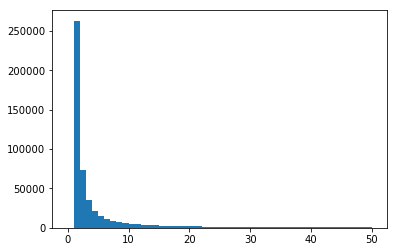

In [19]:
#Word frequency distribution, just for kicks
_ = plt.hist(list(token_counts.values()),range=[0,50],bins=50)

In [20]:
#Select only the tokens that had at least 10 occurences in the corpora.
#Use token_counts.

min_count = 10
# tokens = <tokens from token_counts keys that had at least min_count occurences throughout the dataset>
tokens = [token for token in token_counts.keys() if token_counts[token] > min_count]
print(len(tokens))

85415


In [21]:
token_to_id = {t: i+1 for i,t in enumerate(tokens)}
null_token = "NULL"
token_to_id[null_token] = 0

In [22]:
print("# Tokens:",len(token_to_id))
if len(token_to_id) < 30000:
    print("Alarm! It seems like there are too few tokens. Make sure you updated NLTK and applied correct thresholds -- unless you now what you're doing, ofc")
if len(token_to_id) > 1000000:
    print("Alarm! Too many tokens. You might have messed up when pruning rare ones -- unless you know what you're doin' ofc")

# Tokens: 85416


### Replace words with IDs

Set a maximum length for titles and descriptions.

* If string is longer that that limit - crop it, if less - pad with zeros.
* Thus we obtain a matrix of size [n_samples]x[max_length]
* Element at i,j - is an identifier of word j within sample i

In [23]:
def vectorize(strings, token_to_id, max_len=150):
    token_matrix = []
    for s in strings:
        if type(s) is not str:
            token_matrix.append([0]*max_len)
            continue
        # For Python 2.x
        # s = s.decode('utf8').lower()
        s = s.lower()
        tokens = tokenizer.tokenize(s)
        token_ids = list(map(lambda token: token_to_id.get(token,0), tokens))[:max_len]
        token_ids += [0]*(max_len - len(token_ids))
        token_matrix.append(token_ids)

    return np.array(token_matrix)

In [24]:
desc_tokens = vectorize(df.description.values,token_to_id,max_len = 150)
title_tokens = vectorize(df.title.values,token_to_id,max_len = 15)

### Data format examples

In [25]:
print("Размер матрицы:",title_tokens.shape)
for title, tokens in zip(df.title.values[:10],title_tokens[:10]):
    print(title,'->', tokens[:10],'...')

Размер матрицы: (546240, 15)
Mazda 6, 2008 -> [4050   49 2439    0    0    0    0    0    0    0] ...
Логан стартер -> [7924 2383    0    0    0    0    0    0    0    0] ...
Volkswagen Passat, 2007 -> [3305 4759   69    0    0    0    0    0    0    0] ...
Crescent 550 wa -> [    0  6165 47728     0     0     0     0     0     0     0] ...
Audi Allroad, 2007 -> [  65 4555   69    0    0    0    0    0    0    0] ...
Honda Accord, 2008 -> [3815 3982 2439    0    0    0    0    0    0    0] ...
Главный тормозной цилиндр на деу матиз -> [5895 1945 2670   26 6600 3431    0    0    0    0] ...
Зимние шины всборе с дисками -> [2695 1153 3283   76 1568    0    0    0    0    0] ...
Renault Sandero, 2010 -> [4732 2601 3550    0    0    0    0    0    0    0] ...
Volkswagen Polo, 2010 -> [3305 4190 3550    0    0    0    0    0    0    0] ...


#### As you can see, our preprocessing is somewhat crude. Let us see if that is enough for our network 


## Non-sequences

Some data features are not text samples. E.g. price, # urls, category, etc
They require a separate preprocessing.


In [26]:
#All numeric features
df_numerical_features = df[["phones_cnt","emails_cnt","urls_cnt","price"]]

In [27]:
#One-hot-encoded category and subcategory

from sklearn.feature_extraction import DictVectorizer

categories = []
data_cat_subcat = df[["category","subcategory"]].values

# categories = [A list of dictionaries {"category":category_name, "subcategory":subcategory_name} for each data sample]
categories = [{"category":cat_name, "subcategory":subcat_name} for cat_name, subcat_name in data_cat_subcat]

vectorizer = DictVectorizer(sparse=False)
cat_one_hot = vectorizer.fit_transform(categories)
cat_one_hot = pd.DataFrame(cat_one_hot,columns=vectorizer.feature_names_)

In [28]:
df_non_text = pd.merge(
    df_numerical_features,cat_one_hot,on = np.arange(len(cat_one_hot))
)
del df_non_text["key_0"]

## Split data into training and test

In [29]:
#Target variable - whether or not sample contains prohibited material
target = df.is_blocked.values.astype('int32')
#Preprocessed titles
title_tokens = title_tokens.astype('int32')
#Preprocessed tokens
desc_tokens = desc_tokens.astype('int32')

#Non-sequences
df_non_text = df_non_text.astype('float32')

In [25]:
#Split into training and test set.


#Difficulty selector:
#Easy: split randomly
'''
from sklearn.model_selection import train_test_split
title_tr,title_ts,desc_tr,desc_ts,nontext_tr,nontext_ts,target_tr,target_ts = train_test_split(title_tokens,
                                                                                               desc_tokens,
                                                                                               df_non_text,
                                                                                               target)
'''
#Medium: select test set items that have item_ids strictly above that of training set
middle = len(target) // 2
sitemids, stitle_tokens, sdesc_tokens, starget = (list(t) for t in zip(*sorted(zip(list(df.itemid.values), list(title_tokens),
                                                                          list(desc_tokens), list(target)), 
                                                                        key=lambda x: x[0])))
df_non_text['itemid'] = df.itemid
df_nt = df_non_text.sort_values(by='itemid', kind='quicksort')

assert sum(df_nt.itemid.values == sitemids) == len(df_nt)
print("Test for same sort result passed.")

itemid_tr, itemid_ts = sitemids[:middle], sitemids[middle:]
title_tr,title_ts = stitle_tokens[:middle], stitle_tokens[middle:]
desc_tr,desc_ts = sdesc_tokens[:middle], sdesc_tokens[middle:]
nontext_tr,nontext_ts = df_nt.iloc[:middle], df_nt.iloc[middle:], 
target_tr,target_ts = starget[:middle], starget[middle:]

assert max( itemid_tr) < min(itemid_ts)
print('Test set contains items with item_ids strictly above that of training set.')

# Checking if such simple split provides us with class-balanced train and test sets
print("TRAIN:", sum(target_tr), middle-sum(target_tr))
print("TEST:", sum(target_ts), middle-sum(target_ts))     

data_tuple = (title_tr,title_ts,desc_tr,desc_ts,nontext_tr,nontext_ts,target_tr,target_ts)
#Hard: do whatever you want, but score yourself using kaggle private leaderboard

# title_tr,title_ts,desc_tr,desc_ts,nontext_tr,nontext_ts,target_tr,target_ts = <define_these_variables>

Test for same sort result passed.
Test set contains items with item_ids strictly above that of training set.
TRAIN: 137780 135425
TEST: 137216 135989


### Save preprocessed data [optional]

* The next tab can be used to stash all the essential data matrices and get rid of the rest of the data.
    * Highly recommended if you have less than 1.5GB RAM left
    * To do that, you need to first run it with save_prepared_data=True, then restart the notebook and only run this tab with read_prepared_data=True.



In [30]:
save_prepared_data = False #save
read_prepared_data = True #load

#but not both at once
assert not (save_prepared_data and read_prepared_data)

if save_prepared_data:
    print("Saving preprocessed data (may take up to 3 minutes)")

    import pickle
    with open("preprocessed_data.pcl",'wb') as fout:
        pickle.dump(data_tuple,fout)
    with open("token_to_id.pcl",'wb') as fout:
        pickle.dump(token_to_id,fout)

    print("dobe")
    
elif read_prepared_data:
    print("Reading saved data...")
    
    import pickle
    
    with open("preprocessed_data.pcl",'rb') as fin:
        data_tuple = pickle.load(fin)
    title_tr,title_ts,desc_tr,desc_ts,nontext_tr,nontext_ts,target_tr,target_ts = data_tuple
    with open("token_to_id.pcl",'rb') as fin:
        token_to_id = pickle.load(fin)
        
    #Re-importing libraries to allow staring noteboook from here
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    %matplotlib inline
   
    print("done")

Reading saved data...
done


In [38]:
# post-processing
title_tr = np.asarray(title_tr,dtype='int32')
title_ts = np.asarray(title_ts,dtype='int32')
desc_tr = np.asarray(desc_tr,dtype='int32')
desc_ts = np.asarray(desc_ts,dtype='int32')


## Train the monster

Since we have several data sources, our neural network may differ from what you used to work with.

* Separate input for titles: RNN
* Separate input for description: RNN
* Separate input for categorical features: обычные полносвязные слои или какие-нибудь трюки

These three inputs must be blended somehow - concatenated or added.

* Output: a simple binary classification
    * 1 sigmoidal with binary_crossentropy
    * 2 softmax with categorical_crossentropy - essentially the same as previous one
    * 1 neuron without nonlinearity (lambda x: x) + hinge loss

In [31]:
#libraries
import lasagne
from theano import tensor as T
import theano

In [86]:
#3 inputs and a refere output
title_token_ids = T.matrix("title_token_ids",dtype='int32')
desc_token_ids = T.matrix("desc_token_ids",dtype='int32')
categories = T.matrix("categories",dtype='float32')
target_y = T.ivector("is_blocked")

## NN architecture

In [92]:
title_inp = lasagne.layers.InputLayer((None,title_tr.shape[1]),input_var=title_token_ids)
descr_inp = lasagne.layers.InputLayer((None,desc_tr.shape[1]),input_var=desc_token_ids)
cat_inp = lasagne.layers.InputLayer((None,nontext_tr.shape[1]), input_var=categories)

In [90]:
batchsize, seqlen = descr_inp.input_var.shape
print(batchsize,seqlen)

Subtensor{int64}.0 Subtensor{int64}.0


In [141]:
print(desc_tr.shape)
print(len(token_to_id))

(273205, 150)
85429


In [149]:
# Descriptions

# word-wise embedding. We recommend to start from some 64 and improving after you are certain it works.
# -> output_size=64
num_units = 20
out_size = 64
descr_nn = lasagne.layers.EmbeddingLayer(descr_inp, input_size=len(token_to_id)+1, output_size = out_size)
# descr_nn = RNN or LSTM over embedding, maybe several ones in a stack
descr_nn = lasagne.layers.ReshapeLayer(descr_nn, (-1,1,out_size*desc_tr.shape[1]))
descr_nn = lasagne.layers.LSTMLayer(descr_nn, num_units)

# Titles
# title_nn = <Process titles somehow (title_inp)>
title_nn = lasagne.layers.ReshapeLayer(title_inp, (-1,1,title_tr.shape[1]))
title_nn = lasagne.layers.RecurrentLayer(title_nn, num_units=num_units)
# title_nn = lasagne.layers.RecurrentLayer(title_nn, num_units)

# Non-sequences
# cat_nn = <Process non-sequences(cat_inp)>
cat_nn = lasagne.layers.DenseLayer(cat_inp, num_units=num_units, nonlinearity=lasagne.nonlinearities.rectify)
cat_nn = lasagne.layers.ReshapeLayer(cat_nn, (-1,1,num_units))
# cat_nn = lasagne.layers.DenseLayer(cat_inp, num_units=num_units, nonlinearity=lasagne.nonlinearities.rectify)

In [151]:
# nn = <merge three layers into one (e.g. lasagne.layers.concat) >
nn = lasagne.layers.concat([descr_nn, title_nn, cat_nn])
print(nn.input_shapes)

# nn = lasagne.layers.DenseLayer(nn,your_lucky_number)
# nn = lasagne.layers.DropoutLayer(nn,p=maybe_use_me)
# nn = lasagne.layers.DenseLayer(nn,1,nonlinearity=lasagne.nonlinearities.linear)

nn = lasagne.layers.DenseLayer(nn, num_units)
nn = lasagne.layers.DropoutLayer(nn, p=0.2)
nn = lasagne.layers.DenseLayer(nn,1,nonlinearity=lasagne.nonlinearities.linear)

[(None, 1, 20), (None, 1, 20), (None, 1, 20)]


In [152]:
print(len(token_to_id))

85429


## Loss function
* The standard way:
    * prediction
    * loss
    * updates
    * training and evaluation functions

* Hinge loss
    * $ L_i = \max(0, \delta - t_i p_i) $
    * delta is a tunable parameter: how far should a neuron be in the positive margin area for us to stop bothering about it
    * Function description may mention some +-1 limitations - this is not neccessary, at least as long as hinge loss has a default flag binary = True

In [153]:
#All trainable params
weights = lasagne.layers.get_all_params(nn,trainable=True)

In [156]:
#Simple NN prediction
prediction = lasagne.layers.get_output(nn)[:,0]

#Hinge loss
# loss = lasagne.objectives.binary_hinge_loss(prediction,target_y,delta = what_do_you_think).mean()
loss = lasagne.objectives.binary_hinge_loss(prediction,target_y,delta = 0.9, log_odds=True).mean()

In [159]:
#Weight optimization step
# updates = <your favorite optimizer>
params = lasagne.layers.get_all_params(nn)
updates = lasagne.updates.adagrad(loss, params)


### Determinitic prediction

* In case we use stochastic elements, e.g. dropout or noize
* Compile a separate set of functions with deterministic prediction (deterministic = True)
* Unless you think there's no neet for dropout there ofc. Btw is there?

In [ ]:
#deterministic version
det_prediction = lasagne.layers.get_output(nn,deterministic=True)[:,0]

#equivalent loss function
det_loss = <an excercise in copy-pasting and editing>

### Coffee-lation

In [ ]:
train_fun = theano.function([desc_token_ids,title_token_ids,categories,target_y],[loss,prediction],updates = updates)
eval_fun = theano.function([desc_token_ids,title_token_ids,categories,target_y],[det_loss,det_prediction])

## Training loop

* The regular way with loops over minibatches
* Since the dataset is huge, we define epoch as some fixed amount of samples isntead of all dataset

In [ ]:
#average precision at K

from oracle import APatK, score

In [ ]:
# Out good old minibatch iterator now supports arbitrary amount of arrays (X,y,z)

def iterate_minibatches(*arrays,**kwargs):
    batchsize=kwargs.get("batchsize",100)
    shuffle = kwargs.get("shuffle",True)
    
    if shuffle:
        indices = np.arange(len(arrays[0]))
        np.random.shuffle(indices)
    for start_idx in range(0, len(arrays[0]) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield [arr[excerpt] for arr in arrays]

### Tweaking guide

* batch_size - how many samples are processed per function call
    * optimization gets slower, but more stable, as you increase it.
    * May consider increasing it halfway through training
* minibatches_per_epoch - max amount of minibatches per epoch
    * Does not affect training. Lesser value means more frequent and less stable printing
    * Setting it to less than 10 is only meaningfull if you want to make sure your NN does not break down after one epoch
* n_epochs - total amount of epochs to train for
    * n_epochs = 10**10 and manual interrupting is still an option

Tips:

* With small minibatches_per_epoch, network quality may jump around 0.5 for several epochs
* AUC is the most stable of all three metrics
* Average Precision at top 2.5% (APatK) - is the least stable. If batch_size*minibatches_per_epoch < 10k, it behaves as a uniform random variable.
* Plotting metrics over training time may be a good way to analyze which architectures work better.
* Once you are sure your network aint gonna crash, it's worth letting it train for a few hours of an average laptop's time to see it's true potential

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score

n_epochs = 100
batch_size = 100
minibatches_per_epoch = 100

for i in range(n_epochs):
    #training
    epoch_y_true = []
    epoch_y_pred = []
    
    b_c = b_loss = 0
    for j, (b_desc,b_title,b_cat, b_y) in enumerate(
        iterate_minibatches(desc_tr,title_tr,nontext_tr,target_tr,batchsize=batch_size,shuffle=True)):
        if j > minibatches_per_epoch:break
            
        loss,pred_probas = train_fun(b_desc,b_title,b_cat,b_y)
        
        b_loss += loss
        b_c +=1
        
        epoch_y_true.append(b_y)
        epoch_y_pred.append(pred_probas)
    
    epoch_y_true = np.concatenate(epoch_y_true)
    epoch_y_pred = np.concatenate(epoch_y_pred)
    
    print("Train:")
    print('\tloss:',b_loss/b_c)
    print('\tacc:',accuracy_score(epoch_y_true,epoch_y_pred>0.))
    print('\tauc:',roc_auc_score(epoch_y_true,epoch_y_pred))
    print('\tap@k:',APatK(epoch_y_true,epoch_y_pred,K = int(len(epoch_y_pred)*0.025)+1))
    
    #evaluation
    epoch_y_true = []
    epoch_y_pred = []
    b_c = b_loss = 0
    for j, (b_desc,b_title,b_cat, b_y) in enumerate(
        iterate_minibatches(desc_ts,title_ts,nontext_tr,target_ts,batchsize=batch_size,shuffle=True)):
        if j > minibatches_per_epoch: break
        loss,pred_probas = eval_fun(b_desc,b_title,b_cat,b_y)
        
        b_loss += loss
        b_c +=1
        
        epoch_y_true.append(b_y)
        epoch_y_pred.append(pred_probas)

    epoch_y_true = np.concatenate(epoch_y_true)
    epoch_y_pred = np.concatenate(epoch_y_pred)
    
    print("Val:")
    print('\tloss:',b_loss/b_c)
    print('\tacc:',accuracy_score(epoch_y_true,epoch_y_pred>0.))
    print('\tauc:',roc_auc_score(epoch_y_true,epoch_y_pred))
    print('\tap@k:',APatK(epoch_y_true,epoch_y_pred,K = int(len(epoch_y_pred)*0.025)+1))

In [ ]:
print("If you are seeing this, it's time to backup your notebook. No, really, 'tis too easy to mess up everything without noticing. ")

## Final evaluation

Evaluate network over the entire test set


In [ ]:
#evaluation
epoch_y_true = []
epoch_y_pred = []

b_c = b_loss = 0
for j, (b_desc,b_title,b_cat, b_y) in enumerate(
    iterate_minibatches(desc_ts,title_ts,nontext_tr,target_ts,batchsize=batch_size,shuffle=True)):
    loss,pred_probas = eval_fun(b_desc,b_title,b_cat,b_y)

    b_loss += loss
    b_c +=1

    epoch_y_true.append(b_y)
    epoch_y_pred.append(pred_probas)


epoch_y_true = np.concatenate(epoch_y_true)
epoch_y_pred = np.concatenate(epoch_y_pred)

final_accuracy = accuracy_score(epoch_y_true,epoch_y_pred>0)
final_auc = roc_auc_score(epoch_y_true,epoch_y_pred)
final_apatk = APatK(epoch_y_true,epoch_y_pred,K = int(len(epoch_y_pred)*0.025)+1)

print "Scores:"
print '\tloss:',b_loss/b_c
print '\tacc:',final_accuracy
print '\tauc:',final_auc
print '\tap@k:',final_apatk
score(final_accuracy,final_auc,final_apatk)


## Main task
* https://goo.gl/forms/eJwIeAbjxzVuo6vn1
* Feel like Le'Cun:
    * accuracy > 0.95
    * AUC > 0.97
    * Average Precision at (test sample size * 0.025) > 0.99
    * And perhaps even farther
* Casual mode
    * accuracy > 0.90
    * AUC > 0.95
    * Average Precision at (test sample size * 0.025) > 0.92
* Remember the training, Luke
    * Dropout, regularization
    * Mommentum, RMSprop, ada*
    * etc etc etc
    * If you have background in texts, there may be a way to improve tokenizer, add some lemmatization, etc etc.
    * In case you know how not to shoot yourself in the foot with RNNs, they too may be of some use.